In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [9]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
sub = pd.read_csv('./dataset/submission.csv')

In [10]:
display(train, test, sub)

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,...,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,...,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,...,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,...,2,0,0,4,3,3,3,4,4,2


,id,digit
0,2049,0
1,2050,0
2,2051,0
3,2052,0
4,2053,0
...,...,...
20475,22524,0
20476,22525,0
20477,22526,0
20478,22527,0


In [11]:
train['digit'].value_counts()

2    233
5    225
6    212
4    207
3    205
1    202
9    197
7    194
0    191
8    182
Name: digit, dtype: int64

In [13]:
train2 = train.drop(['id', 'digit', 'letter'], axis=1)
test2 = test.drop(['id', 'letter'], axis=1)

In [15]:
train2 = train2.values
test2 = test2.values

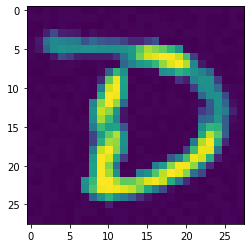

In [18]:
plt.imshow(train2[100].reshape(28, 28))

In [20]:
train2 = train2.reshape(-1, 28, 28, 1)
test2 = test2.reshape(-1, 28, 28, 1)

In [21]:
train2 = train2 / 255.0
test2 = test2 / 255.0

In [22]:
idg = ImageDataGenerator(height_shift_range=(-1,1), width_shift_range=(-1,1))
idg2 = ImageDataGenerator()

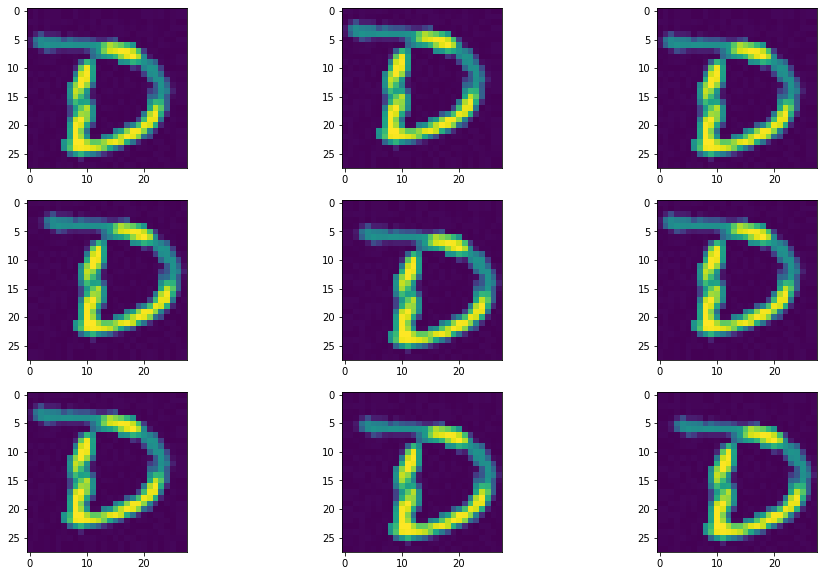

In [32]:
sample_data = train2[100].copy()
sample_data.shape
sample = expand_dims(sample_data, 0)
sample_datagen = ImageDataGenerator(height_shift_range=(-1,1), width_shift_range=(-1,1))
sample_generator = sample_datagen.flow(sample, batch_size=1)

plt.figure(figsize=(16,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    sample_batch = sample_generator.next()
    sample_image = sample_batch[0]
    plt.imshow(sample_image.reshape(28,28))

In [33]:
skf = StratifiedKFold(n_splits=40, random_state=42, shuffle=True)

In [39]:
reLR = ReduceLROnPlateau(patience=100,verbose=1,factor=0.5) #learning rate scheduler
es = EarlyStopping(patience=160, verbose=1)

val_loss_min = []
result = 0
nth = 0

for train_index, valid_index in skf.split(train2,train['digit']) :
    
    mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1)
    
    x_train = train2[train_index]
    x_valid = train2[valid_index]    
    y_train = train['digit'][train_index]
    y_valid = train['digit'][valid_index]
    
    train_generator = idg.flow(x_train,y_train,batch_size=8)
    valid_generator = idg2.flow(x_valid,y_valid)
    test_generator = idg2.flow(test2,shuffle=False)
    
    model = Sequential()
    
    model.add(Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(10,activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.002,epsilon=None),metrics=['acc'])
    
    learning_history = model.fit_generator(train_generator,epochs=2000, validation_data=valid_generator, callbacks=[es,mc,reLR])
    
    # predict
    model.load_weights('best_cvision.h5')
    result += model.predict_generator(test_generator,verbose=True)/40
    
    # save val_loss
    hist = pd.DataFrame(learning_history.history)
    val_loss_min.append(hist['val_loss'].min())
    
    nth += 1
    print(nth, '번째 학습을 완료했습니다.')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2000
250/250 [==============================] - ETA: 0s - loss: 2.6374 - acc: 0.1598
Epoch 00001: val_loss improved from inf to 6.22891, saving model to best_cvision.h5
250/250 [==============================] - 32s 126ms/step - loss: 2.6374 - acc: 0.1598 - val_loss: 6.2289 - val_acc: 0.0962 - lr: 0.0020
Epoch 2/2000
250/250 [==============================] - ETA: 0s - loss: 2.0927 - acc: 0.2725
Epoch 00002: val_loss did not improve from 6.22891
250/250 [==============================] - 31s 123ms/step - loss: 2.0927 - acc: 0.2725 - val_loss: 7.7602 - val_acc: 0.0962 - lr: 0.0020
Epoch 3/2000
250/250 [==============================] - ETA: 0s - loss: 1.8080 - acc: 0.3632
Epoch 00003: val_loss improved from 6.22891 to 2.07667, saving model to best_cvision.h5
250/250 [==============================] - 32s 127ms/step - loss: 1.8080 - acc: 0.3632 - val_loss: 2.0767 - val_acc: 0.4038 - lr: 0.0020
Epoch 4/200

Epoch 28/2000
250/250 [==============================] - ETA: 0s - loss: 0.5886 - acc: 0.8056
Epoch 00028: val_loss did not improve from 0.35800
250/250 [==============================] - 31s 125ms/step - loss: 0.5886 - acc: 0.8056 - val_loss: 0.3602 - val_acc: 0.8654 - lr: 0.0020
Epoch 29/2000
250/250 [==============================] - ETA: 0s - loss: 0.4851 - acc: 0.8422
Epoch 00029: val_loss improved from 0.35800 to 0.16041, saving model to best_cvision.h5
250/250 [==============================] - 31s 125ms/step - loss: 0.4851 - acc: 0.8422 - val_loss: 0.1604 - val_acc: 0.9038 - lr: 0.0020
Epoch 30/2000
250/250 [==============================] - ETA: 0s - loss: 0.5375 - acc: 0.8287
Epoch 00030: val_loss did not improve from 0.16041
250/250 [==============================] - 30s 121ms/step - loss: 0.5375 - acc: 0.8287 - val_loss: 0.3635 - val_acc: 0.8846 - lr: 0.0020
Epoch 31/2000
250/250 [==============================] - ETA: 0s - loss: 0.4917 - acc: 0.8482
Epoch 00031: val_loss d

Epoch 57/2000
250/250 [==============================] - ETA: 0s - loss: 0.3045 - acc: 0.9053
Epoch 00057: val_loss did not improve from 0.16041
250/250 [==============================] - 30s 118ms/step - loss: 0.3045 - acc: 0.9053 - val_loss: 0.3410 - val_acc: 0.8269 - lr: 0.0020
Epoch 58/2000
250/250 [==============================] - ETA: 0s - loss: 0.3518 - acc: 0.8958
Epoch 00058: val_loss did not improve from 0.16041
250/250 [==============================] - 30s 120ms/step - loss: 0.3518 - acc: 0.8958 - val_loss: 0.4115 - val_acc: 0.8654 - lr: 0.0020
Epoch 59/2000
250/250 [==============================] - ETA: 0s - loss: 0.3719 - acc: 0.8843
Epoch 00059: val_loss did not improve from 0.16041
250/250 [==============================] - 29s 118ms/step - loss: 0.3719 - acc: 0.8843 - val_loss: 0.3500 - val_acc: 0.9038 - lr: 0.0020
Epoch 60/2000
250/250 [==============================] - ETA: 0s - loss: 0.3411 - acc: 0.8963
Epoch 00060: val_loss did not improve from 0.16041
250/250 [

250/250 [==============================] - ETA: 0s - loss: 0.2320 - acc: 0.9309
Epoch 00086: val_loss did not improve from 0.16041
250/250 [==============================] - 27s 108ms/step - loss: 0.2320 - acc: 0.9309 - val_loss: 0.4222 - val_acc: 0.8462 - lr: 0.0020
Epoch 87/2000
250/250 [==============================] - ETA: 0s - loss: 0.2064 - acc: 0.9394
Epoch 00087: val_loss did not improve from 0.16041
250/250 [==============================] - 27s 107ms/step - loss: 0.2064 - acc: 0.9394 - val_loss: 0.2506 - val_acc: 0.9038 - lr: 0.0020
Epoch 88/2000
250/250 [==============================] - ETA: 0s - loss: 0.2276 - acc: 0.9304
Epoch 00088: val_loss did not improve from 0.16041
250/250 [==============================] - 29s 115ms/step - loss: 0.2276 - acc: 0.9304 - val_loss: 0.3431 - val_acc: 0.9038 - lr: 0.0020
Epoch 89/2000
250/250 [==============================] - ETA: 0s - loss: 0.2023 - acc: 0.9329
Epoch 00089: val_loss did not improve from 0.16041
250/250 [==============

250/250 [==============================] - ETA: 0s - loss: 0.2303 - acc: 0.9284
Epoch 00115: val_loss did not improve from 0.16041
250/250 [==============================] - 28s 113ms/step - loss: 0.2303 - acc: 0.9284 - val_loss: 0.3152 - val_acc: 0.8846 - lr: 0.0020
Epoch 116/2000
250/250 [==============================] - ETA: 0s - loss: 0.2340 - acc: 0.9254
Epoch 00116: val_loss did not improve from 0.16041
250/250 [==============================] - 28s 111ms/step - loss: 0.2340 - acc: 0.9254 - val_loss: 0.3433 - val_acc: 0.9038 - lr: 0.0020
Epoch 117/2000
250/250 [==============================] - ETA: 0s - loss: 0.1898 - acc: 0.9399
Epoch 00117: val_loss did not improve from 0.16041
250/250 [==============================] - 28s 113ms/step - loss: 0.1898 - acc: 0.9399 - val_loss: 0.3693 - val_acc: 0.9038 - lr: 0.0020
Epoch 118/2000
250/250 [==============================] - ETA: 0s - loss: 0.1798 - acc: 0.9474
Epoch 00118: val_loss did not improve from 0.16041
250/250 [===========

KeyboardInterrupt: 

In [ ]:
display(val_loss_min, np.mean(val_loss_min))

In [ ]:
model.summary()

In [ ]:
sub['digit'] = result.argmax(1)

In [ ]:
sub

In [ ]:
sub.to_csv('predict(95%).csv', index=False)